In [116]:
%run SetUp.ipynb

In [4]:
angles_from_vqe = [0.1781, 0.10]

## Define VQE form

In [5]:
# VQE
# odd layer theta0*POYPO theta1*P1YP1 then even layer

def PYP(angle1,angle2, nq,state):
    n_sets = int(nq/2)
    for mm in range(n_sets):
        bb,cc,dd = (2*mm+1)%nq,(2*mm+2)%nq,(2*mm+3)%nq
        state = sp.sparse.linalg.expm_multiply(-1j * angle1 * pad_op(bb,nq,proj0) @ pad_op(cc,nq,y) @ pad_op(dd,nq,proj0),state) 
        state = sp.sparse.linalg.expm_multiply(-1j * angle2 * pad_op(bb,nq,proj1) @ pad_op(cc,nq,y) @ pad_op(dd,nq,proj1),state)
    for m in range(n_sets):
        aa,bb,cc = (2*m)%nq,(2*m+1)%nq,(2*m+2)%nq
        state =  sp.sparse.linalg.expm_multiply(-1j * angle1 * pad_op(aa,nq,proj0) @ pad_op(bb,nq,y) @ pad_op(cc,nq,proj0),state)
        state =  sp.sparse.linalg.expm_multiply(-1j * angle2 * pad_op(aa,nq,proj1) @ pad_op(bb,nq,y) @ pad_op(cc,nq,proj1),state)
    return state


In [93]:
# reverse the vacuum preparation

def reverse_vac(angle1,angle2,state,nq):
    n_sets = int(nq/2)
    for m in range(n_sets):
        aa,bb,cc = (2*m)%nq,(2*m+1)%nq,(2*m+2)%nq
        state =  sp.sparse.linalg.expm_multiply(1j * angle1 * pad_op(aa,nq,proj0) @ pad_op(bb,nq,y) @ pad_op(cc,nq,proj0),state)
        state =  sp.sparse.linalg.expm_multiply(1j * angle2 * pad_op(aa,nq,proj1) @ pad_op(bb,nq,y) @ pad_op(cc,nq,proj1),state)
    for mm in range(n_sets):
        bb,cc,dd = (2*mm+1)%nq,(2*mm+2)%nq,(2*mm+3)%nq
        state = sp.sparse.linalg.expm_multiply(1j * angle1 * pad_op(bb,nq,proj0) @ pad_op(cc,nq,y) @ pad_op(dd,nq,proj0),state) 
        state = sp.sparse.linalg.expm_multiply(1j * angle2 * pad_op(bb,nq,proj1) @ pad_op(cc,nq,y) @ pad_op(dd,nq,proj1),state)
    return state


# Classical Calculation 20 qubits

## Initiate States

In [6]:
nQQ = 20

In [8]:
# Generate Fake Vacuum
def fake_vac(nq):
    return sp.sparse.csr_array(ft.reduce(sp.sparse.kron, [[1.,0.]]* nq).toarray()).transpose()


In [9]:

# Turn on 3 links in the middle
def activate(init,nq): # init is a function of nq, init(nq) is a state
    if nq <= 5: raise Exception (" Size of system too small. Operate on number of qubits >= 6")
    loc = (nq-5) // 2
    P0XXXP0 = math.pi/2* ft.reduce(sp.sparse.kron,[proj0,x,x,x,proj0])
    act_mat =ft.reduce(sp.sparse.kron, [sp.sparse.identity(2**(loc)),P0XXXP0,sp.sparse.identity(2**(nq-loc-5))]) 
    return sp.sparse.linalg.expm_multiply(-1j * act_mat,init(nq))

In [37]:

# activate 1 site. 

def activate1(init,loc,nq): # init is a function of nq, init(nq) is a state, loc is which link is activated
    #P0XP0 = math.pi/2* ft.reduce(sp.sparse.kron,[proj0,x,proj0])
    act_mat =ft.reduce(sp.sparse.kron, [sp.sparse.identity(2**(loc)),x,sp.sparse.identity(2**(nq-loc-1))]) 
    return act_mat @ init(nq)

In [108]:
# Initialize State
# vacuum = np.reshape(PYP(-0.17939731, -0.10569839,nQ,fake_vac(nQQ)).toarray(),-1)
# initial = np.reshape(PYP(-0.17939731, -0.10569839,nQ,activate(fake_vac,nQQ)).toarray(),-1)
vacuum = PYP(-0.17939731, -0.10569839,nQ,fake_vac(nQQ))
initial = PYP(-0.17939731, -0.10569839,nQ,activate(fake_vac,nQQ))

In [110]:
testt = reverse_vac(-0.17939731, -0.10569839,vacuum,nQQ)

In [109]:
sp.linalg.norm(initial)

<1048576x1 sparse array of type '<class 'numpy.complex128'>'
	with 59050 stored elements in Compressed Sparse Column format>

In [120]:
initial1 = PYP(-0.17939731, -0.10569839,nQ,activate1(fake_vac,10,nQQ))

In [102]:
testt = reverse_vac(-0.17939731, -0.10569839,initial1,nQQ)

In [106]:
sp.sparse.linalg.expm_multiply(-1j * Hf * del_t,fake_vac(nQQ))

<1048576x1 sparse array of type '<class 'numpy.complex128'>'
	with 1048576 stored elements in Compressed Sparse Column format>

### Check the states initiated

[0.03183961600545533,
 0.029855655252201158,
 0.031839616005455394,
 0.029855655252201175,
 0.031839616005455415,
 0.029855655252201165,
 0.031839616005455366,
 0.02985565525220115,
 0.03183961600545535,
 0.02985565525220117,
 0.03183961600545532,
 0.029855655252201165,
 0.03183961600545534,
 0.029855655252201165,
 0.03183961600545532,
 0.029855655252201158,
 0.03183961600545533,
 0.029855655252201154,
 0.03183961600545533,
 0.029855655252201158]

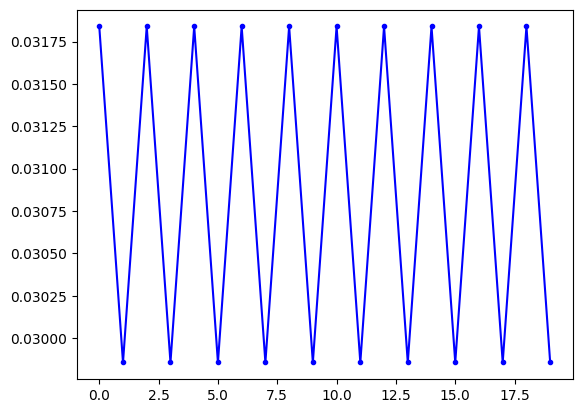

In [117]:
plot_E_per_site(vacuum,nQQ)

[0.031839616005455394,
 0.02985565525220111,
 0.03183961600545543,
 0.02985565525220113,
 0.03183961600545545,
 0.029855655252201158,
 0.03183961600545537,
 0.0003543942188199803,
 1.0000000000000009,
 0.988869394066837,
 1.0000000000000009,
 0.00035439421881998005,
 0.03183961600545537,
 0.02985565525220116,
 0.03183961600545537,
 0.02985565525220117,
 0.0318396160054554,
 0.029855655252201165,
 0.03183961600545538,
 0.02985565525220116]

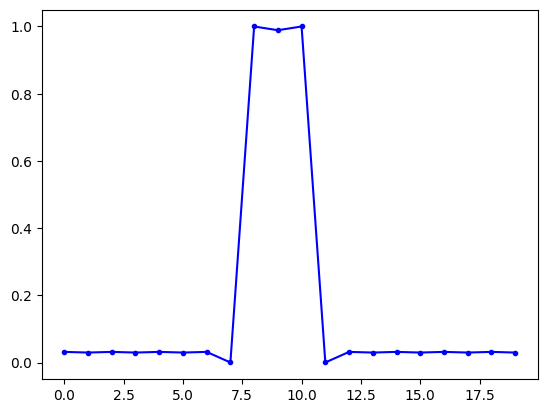

In [118]:
plot_E_per_site(initial,nQQ)

[0.03183961600545394,
 0.0298556552521997,
 0.03183961600545406,
 0.02985565525219984,
 0.03183961600545401,
 0.029855655252199964,
 0.03183961600545443,
 0.029855655252199957,
 0.03183961600545505,
 0.0013245938246995103,
 0.9681603839943896,
 0.00132459382469951,
 0.03183961600545509,
 0.02985565525219997,
 0.031839616005454485,
 0.02985565525219997,
 0.031839616005454055,
 0.029855655252199843,
 0.03183961600545409,
 0.029855655252199707]

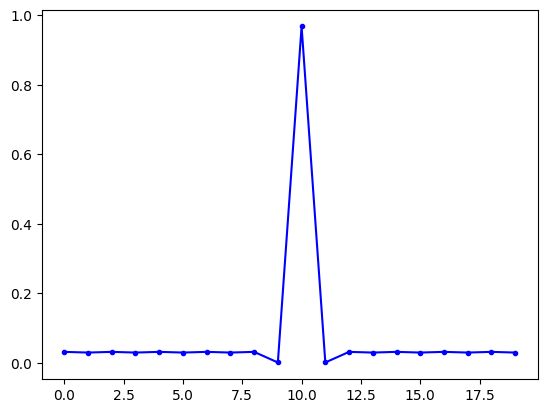

In [121]:
plot_E_per_site(initial1,nQQ)

## Time Evolution

In [13]:
Hf = Hfull(nQQ,m,g).to_matrix(sparse = True)

### Vacuum Propagation

In [32]:
# check vacuum propagation
# this is not Trotterized

del_t = 0.8

ts = np.arange(0, 10, del_t) 
final_vacuum = vacuum.copy()

exp_val = []
for i in range(len(ts)):
    final_vacuum = sp.sparse.linalg.expm_multiply(-1j * Hf * del_t,final_vacuum)
    exp_val.append(overlap(final_vacuum,vacuum))


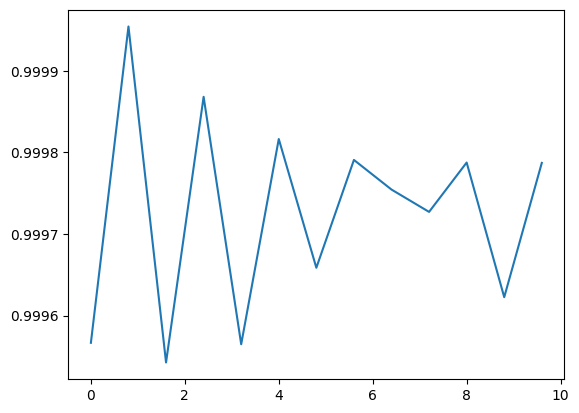

In [33]:
plt.plot(ts,exp_val)

### Activate 1 link

In [51]:
# activate 1 site and time evolution

del_t = 0.8

ts = np.arange(0, 40, del_t) 
sites = np.arange(0, nQQ, 1) 

final_state = initial1.copy()

Data = []
for i in range(len(ts)):
    final_state = sp.sparse.linalg.expm_multiply(-1j * Hf * del_t,final_state)
    E_exps = []
    for loc in sites:
        E_exps += [(np.real(final_state.conj().T @ He_persite_scipy(nQQ,g,loc) @ final_state))] # Should be CT(state).H.state
    Data.append(E_exps)

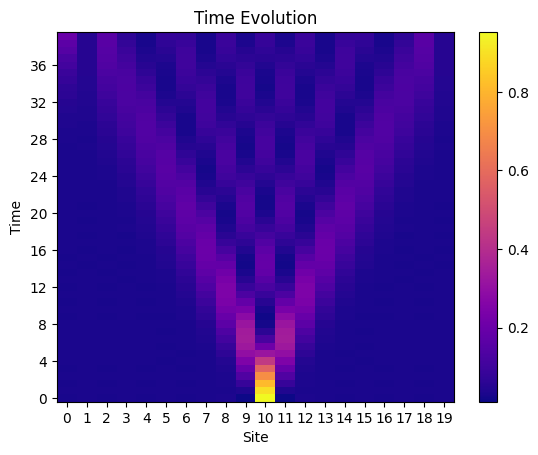

In [52]:
plt.pcolormesh(sites, ts, Data)
plt.colorbar()
plt.set_cmap('plasma')
# plt.clim(0.9729,0.99)
plt.xticks(sites)
plt.yticks(ts[::5])
plt.xlabel("Site")
plt.ylabel("Time")
plt.title("Time Evolution")
plt.show()

In [ ]:
# activate 1 site and time evolution
# Sum of P1 expectationg value and sum of P0P1+P1P0 expectation value

del_t = 0.8

ts = np.arange(0, 2, del_t) 
sites = np.arange(0, nQQ, 1) 

final_state = initial1.copy()

# save values at t = 0 point
E_exps = 0
M_exps = 0
for loc in sites:
    re_final = reverse_vac(-0.17939731, -0.10569839,final_state,nQQ)
    E_exps += np.real(re_final.conj().T @ He_persite_scipy(nQQ,loc) @ re_final)[0]
    M_exps += np.real(re_final.conj().T @ Hm_persite(nQQ,loc).to_matrix(sparse = True) @ re_final)[0]
        
E_list = [E_exps]
M_list = [M_exps/2]

# for i in range(len(ts)-1):
#     final_state = sp.sparse.linalg.expm_multiply(-1j * Hf * del_t,final_state)
#     E_exps = 0
#     M_exps = 0
#     for loc in sites:
#         re_final = reverse_vac(-0.17939731, -0.10569839,final_state,nQQ)
#         E_exps += np.real(re_final.conj().T @ He_persite_scipy(nQQ,loc) @ re_final)
#         M_exps += np.real(re_final.conj().T @ Hm_persite(nQQ,loc).to_matrix(sparse = True) @ re_final)
#     E_list.append(E_exps)
#     M_list.append(M_exps/2)

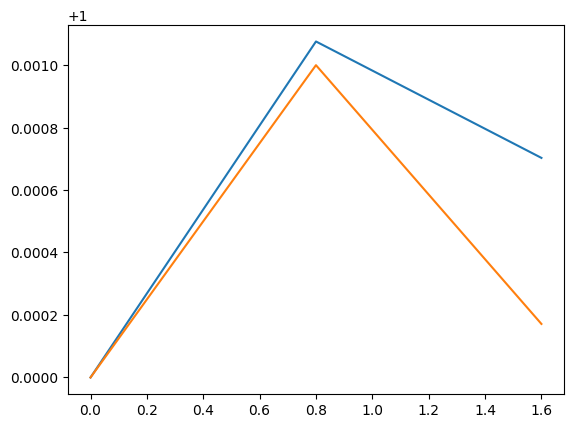

In [ ]:
plt.plot(ts,E_list)
plt.plot(ts,M_list)

### Activate 3 links

In [58]:
# activate 3 site and time evolution
# P0P1 + P1P0 per site

del_t = 0.8

ts = np.arange(0, 40, del_t) 
sites = np.arange(0, nQQ, 1) 

final_state = initial.copy()

Data = []
for i in range(len(ts)):
    final_state = sp.sparse.linalg.expm_multiply(-1j * Hf * del_t,final_state)
    E_exps = []
    for loc in sites:
        E_exps += [(np.real(final_state.conj().T @ Hm_persite(nQQ,loc).to_matrix(sparse = True) @ final_state))] # Should be CT(state).H.state
    Data.append(E_exps)


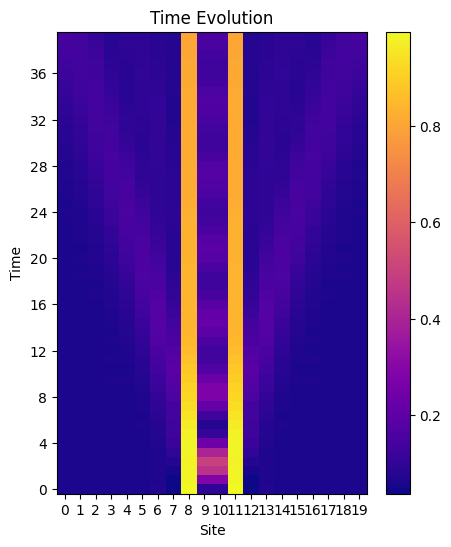

In [63]:
plt.figure(figsize=(5, 6))
plt.pcolormesh(sites, ts, Data)
plt.colorbar()
plt.set_cmap('plasma')
# plt.clim(0.9729,0.99)
plt.xticks(sites)
plt.yticks(ts[::5])
plt.xlabel("Site")
plt.ylabel("Time")

plt.title("Time Evolution")
plt.show()